# Music and the Homo/Heterogenization of Culture

In "The Culture Industry: Enlightenment as Mass Deceoption", Horkheimer and Adorno claim that "Culture today is infecting everything with sameness". <br>
They argue that while variations do exist, the variation is not true variation -- rather, like a wheel spinning in place, it gives the appearance of differentiation, but there ultimately is no true difference. Either the differences are surface level (such as the extravagant use of technology in films) and do not relate to the meaning of the products themselves, or they do not varying from existing styles. Everything is created within the same pre-existing types. <br>
<br>
Here, we will evaluate this claim of "sameness" in relation to the popular music industry, using data from the Billboard Hot 100.

In [16]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import json
import datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12})
import altair as alt

import nltk
import string
from gensim import corpora, models

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.simplefilter(action='ignore')

# Read in data

In [3]:
music_df = pd.read_csv('pt1_files\music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)
print(music_df.columns)
music_df.head(2)

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender'],
      dtype='object')


,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,...,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group


In [4]:
f = open('pt1_files\directdata.json')
direct_list = eval(f.read())
f.close()

direct_dict = {}
for i in range(len(direct_list)):
    direct_dict[direct_list[i]['year']] = pd.json_normalize(direct_list[i]['songs'])
direct_df = direct_dict[1950]
direct_df['year'] = 1950
for i in range(1951, 2016):
    direct_dict[i]['year'] = i
    direct_df = pd.concat([direct_df,direct_dict[i]])

In [5]:
direct_df

,artist,num_lines,tags,f_k_grade,year,pos,num_syllables,difficult_words,fog_index,title,num_dupes,flesch_index,num_words,sentiment.neg,sentiment.neu,sentiment.pos,sentiment.compound
0,Nat King Cole,17,"[jazz, pop, swing]",2.9,1950,2,189.0,13,5.2,Mona Lisa,10,88.74,145,0.155,0.646,0.199,0.8443
1,Andrews Sisters,31,[],3.3,1950,17,270.9,40,4.4,I Wanna Be Loved,32,82.31,189,0.036,0.740,0.224,0.9897
2,Patti Page,16,"[country, pop]",2.9,1950,18,174.6,5,5.2,Tennessee Waltz,10,88.74,138,0.053,0.596,0.351,0.9948
3,Tennessee Ernie Ford,18,[],0.9,1950,20,135.9,10,4.4,I'll Never Be Free,3,99.23,117,0.167,0.602,0.231,0.8842
4,Patti Page,3,"[country, pop]",6.0,1950,21,46.8,9,6.0,All My Love,0,69.79,32,0.070,0.850,0.079,0.0772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Alessia Cara,51,[],2.1,2015,94,570.6,42,5.6,Here,13,96.18,469,0.041,0.840,0.120,0.9896
72,Mr. Probz,22,[pop],1.7,2015,95,169.2,15,4.0,Waves,8,91.78,126,0.014,0.801,0.184,0.9702
73,Ne-Yo,26,[electronic/dance],0.1,2015,97,217.8,16,4.8,She Knows,21,106.67,193,0.059,0.874,0.067,0.5459
74,One Direction,52,[pop],2.9,2015,98,399.6,31,4.0,Night Changes,34,83.32,296,0.105,0.869,0.026,-0.9628


In [6]:
# getting position of song in top 100
# and getting tags for each song
music_df = music_df.rename(columns={'pos': 'pos_sentiment', 'neg': 'neg_sentiment', 'neu': 'neu_sentiment'})

direct_df = direct_df.set_index(['year','artist','title'])[['pos','tags']]
music_df = music_df.set_index(['year','artist','title'])
music_df = pd.merge(music_df,direct_df[['pos','tags']],how='left',left_index=True,right_index=True).reset_index()

In [7]:
numerical = ['difficult_words','num_words','num_dupes',
'num_lines','duration_ms',
'fog_index','f_k_grade','flesch_index',
'speechiness','acousticness','instrumentalness',
'tempo','liveness','energy','danceability','loudness',
'pos_sentiment','neg_sentiment','neu_sentiment']

# Are there big hits that are imitated after?

Horkheimer and Adorno argue that culture tends toward sameness through imitating what has previously demonstrated success. Therefore, songs that are different but successful should have many imitators. <br>
To see if this is true, I take the first ten years in the dataset and use their numerical metrics and PCA decomposition to create a basis that captures at least 95% of the information. From there, I find if there's a song in the next year's top ten whos residual is an outlier. Then, I repeat this for the next year, using all the previous years numerical values to create a new basis. <br>

In [8]:
standardized = music_df.copy()
standardized[numerical] = StandardScaler().fit_transform(music_df[numerical])

90th percentile = 1.462021149910153


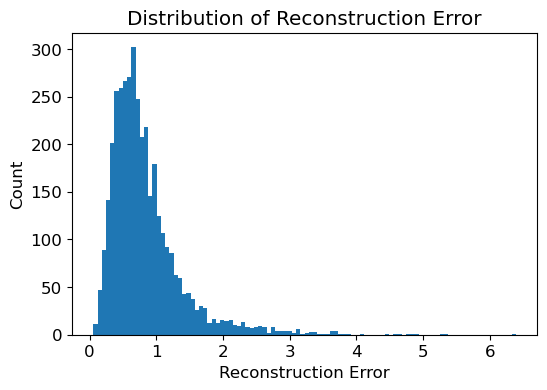

In [9]:
# build a PCA for the past years, find a song whos vector does not fit well into the existing PCA
all_reconstruct_err = []
for i in range(1960, 2015+1): # need ten years to start w
    past_df = standardized[['year','pos']+numerical].query('year < @i')
    pca = PCA(0.95)
    pca.fit(past_df[numerical])
    # print(i, sum(pca.explained_variance_ratio_), pca.n_components_)

    current_df = standardized.query('year == @i')
    current_pca = pca.transform(current_df[numerical])
    current_reconstruct = pca.inverse_transform(current_pca)
    current_reconstruct_err = np.linalg.norm(current_df[numerical] - current_reconstruct, axis=1)
    all_reconstruct_err.extend(current_reconstruct_err)
# find what residuals stand out
plt.hist(all_reconstruct_err, bins=100)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Error')
print(f'90th percentile = {np.percentile(all_reconstruct_err, 90)}')

In [10]:
standardized['reconstruct_err'] = [0]*len(standardized.query('year < 1960')) + all_reconstruct_err
unique = standardized.query('reconstruct_err >= 2').query('pos < 10')

In [11]:
# find the songs with highest cosine similarity to the unique songs
compare = standardized[~standardized.index.isin(unique.index)].copy()
for i in unique.index:
    compare['similarity_'+str(i)] = cosine_similarity(compare[numerical], unique.loc[i,numerical].values.reshape(1,-1)).flatten()

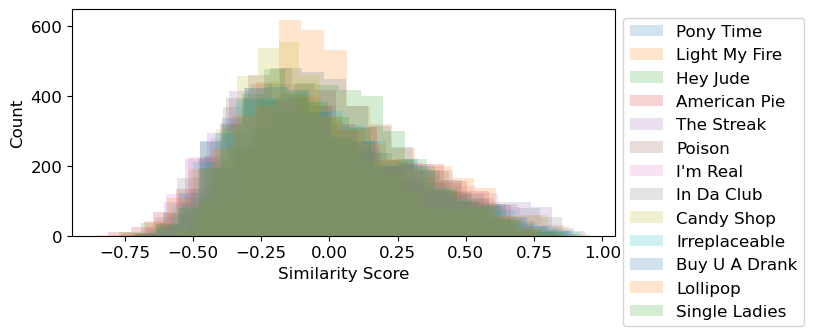

In [12]:
# find threshold for similarity
infl_5pct = {}
plt.figure(figsize=(7,3))
for i in unique.index:
    plt.hist(compare['similarity_'+str(i)], bins=20, alpha = 0.2, label = unique.loc[i,'title'])
    infl_5pct[i] = np.percentile(compare['similarity_'+str(i)], 95)
plt.legend(bbox_to_anchor=[1,1])
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.show()

In [19]:
influenced = {}
for i in unique.index:
    # influenced[i] = compare.query(f'similarity_{i} > @infl_5pct[@i]')
    influenced[i] = compare.query(f'similarity_{i} > 0.5')
    # print(len(influenced[i]))

In [41]:
all_influenced = pd.DataFrame(columns=['year','artist','title','similarity'])
for song in influenced.keys():
    df = influenced[song][['year','artist','title','pos',f'similarity_{song}']]\
        .rename(columns={f'similarity_{song}':'similarity','pos':'position'})
    df['Influencer'] = unique.loc[song]['title']
    df['Year Inspired'] = unique.loc[song]['year'].astype(int)
    all_influenced = pd.concat([all_influenced,df])

In [43]:
# convert year to datetime
all_influenced['year'] = all_influenced['year'].apply(lambda x: datetime.datetime.strptime(str(x),"%Y"))
all_influenced['Year Inspired'] = all_influenced['Year Inspired'].apply(lambda x: datetime.datetime.strptime(str(int(x)),"%Y"))

In [44]:
dots = alt.Chart(all_influenced).mark_point().encode(
    x = alt.X('year:T',scale=alt.Scale(zero=False),axis=alt.Axis(title='Year of Release')),
    y= alt.X(f'similarity',scale=alt.Scale(zero=False, domain=[0.5,1]),axis=alt.Axis(title='Similarity Score')),
#     facet=alt.Facet('Influencer:N'),
    tooltip = alt.Tooltip(['title','artist','position'])
).properties(
    width=170,
    height=170
)
release = alt.Chart(all_influenced).mark_rule(color='red').encode(
    x = alt.X('Year Inspired:T',axis=alt.Axis(title='Year of Release'))
).properties(
    width=170,
    height=170
)

infl_plots = dots+release

alt.ConcatChart(
    concat=[
      infl_plots.transform_filter(alt.datum.Influencer == value).properties(title=f'{value}')
      for value in sorted(all_influenced.Influencer.unique())
    ],
    columns=4
).configure_title(
    fontSize=20,
    anchor='middle',
    align='left'
# ).resolve_axis(
#     x='independent',
#     y='independent'
# ).resolve_scale(
#     x='independent', 
#     y='independent'
)

alt.ConcatChart(...)